# Michelin survivor
Michelin-rated restaurants are some of the highest-grossing businesses in the fine-dining industry – a $10 billion market in the U.S. Inversely, losing a Michelin star can make a business less profitable, with up to 40% of these businesses closing within 5 years. In this notebook which I developed at Insight Data Science, I used Yelp reviews to develop a product that forecasts the risk of a restaurant losing a Michelin star and provides actionable insights to restauranteurs and investors on how to improve if their business is deemed at risk. Restaurants have vastly different timelines - from opening, getting Michelin-rated, to closing shop - so wrangling 200k+ Yelp reviews into usable features was a significant challenge to overcome, and vital in broader risk assessment and survival analysis problems.

In [5]:
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd


michelin_data    = pd.read_csv('datasets/michelin_nyc_stars.csv')
michelin_data    = michelin_data.iloc[:,1:]

### Preprocess Michelin Data


In [6]:
def process_michelin(michelin_data):
    #-----------------------------------------------------------
    # returns all michelin data in accordance with yelp data for NYC restaurants
    #-----------------------------------------------------------
    def rename_restos(michelin_data):
        michelin_data['name'] = michelin_data['name'].replace(to_replace = {'breslin': 'the-breslin',
                                   'cho-dang-gol': 'cho-dang-gol-korean-restaurant',
                                    'el-parador': 'el-parador-cafe',
                                    'ginza-onodera': 'sushi-ginza-onodera',
                                    'good-fork': 'the-good-fork',
                                    'grammercy-tavern': 'gramercy-tavern',
                                                           'great-ny-noodletown': 'great-ny-noodle-town',
                                                            'katzs': 'katzs-delicatessen',
                                                            'kurumazushi': 'kuruma-zushi',
                                                          'modern' : 'the-modern',
                                                           'modern,-the': 'the-modern',
                                                          'sevilla': 'sevilla-restaurant',
                                                           'spotted-pig' : 'the-spotted-pig',
                                                            'gunter-seeger-ny': 'gunter-seeger'})

        michelin_data['name'] = (michelin_data['name'].str.replace('é', 'e').str.replace('ë', 'e').str.replace('ü', 'u'))
        michelin_data         = michelin_data.drop_duplicates(keep = 'first')
        michelin_data         = michelin_data.drop([216,217], axis = 0)
        
        return michelin_data
    
    def drop_duplicates(michelin_data):

        dupes = michelin_data.name[michelin_data.name.duplicated()]
        dupes = michelin_data.loc[michelin_data.name.duplicated(keep = False)].sort_values(by = 'name')

        new = pd.DataFrame(columns = dupes.columns)
        i = 0
        for each in dupes.name.unique():
            new.loc[i] = dupes.loc[(dupes.name==each)].sum(axis = 0, numeric_only = True)
            i+=1
        new['name'] = dupes.name.unique()
        michelin_data = michelin_data.drop(dupes.index, axis = 0)
        michelin_data = pd.concat([michelin_data,new], axis = 0).reset_index(drop = True)
        
        return michelin_data
    
    michelin_data = drop_duplicates(rename_restos(michelin_data))
    
    return michelin_data

michelin_data = process_michelin(michelin_data)
michelin_data.head()

,name,stars_2007,stars_2008,stars_2009,stars_2010,stars_2011,stars_2012,stars_2013,stars_2014,stars_2015,stars_2016,stars_2017,stars_2018,stars_2019
0,15-east,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
1,a-voce,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,a-voce-columbus,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,adour,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,agern,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


### Process Yelp review data
 Process Yelp restaurant names then get TF/IDF weights using NMF factorization with hand-labeled topics
 
 #### Start with raw data dataframe

In [7]:
from sklearn import preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import numpy as np

def get_yelp_df():
    
    #-----------------------------------------------------------
    # returns all yelp data and topic weights from tf/idf
    # for a specific year of restaurants on the michelin guide
    #-----------------------------------------------------------
    
    # V_1 added first 06/10/19
    old_data  = pd.read_csv('datasets/michelin_yelp_reviews.csv')

    # added later
    new_data  = pd.read_csv('datasets/yelp_data_additional.csv', header = None, names = ['restaurant', 'date', 'rating', 'review'])

    yelp_data = pd.concat([new_data, old_data], axis = 0)
    yelp_data['restaurant'] = (
                                yelp_data['restaurant']
                                .str.replace('é', 'e')
                                .str.replace('ë', 'e')
                                .str.replace('ū', 'u')
                                .str.replace('ü', 'u')
                                .str.replace('gunter-seeger-ny', 'gunter-seeger')
                              )
    yelp_data = yelp_data.drop_duplicates(keep = 'first')

    yelp_data['review'] = (
                                yelp_data.review
                               .str.replace('\\\\xc2', '')
                               .str.replace('\\\\xa0', '')
                               .str.replace('\\\xa0', '')
                               .str.lower()
                               .str.replace('\d+', '')
                               .str.replace(r'[^\w\s]+', '')
                               .str.replace('cocktails', 'cocktail')
                               .str.replace('zzs', '')
                               .str.replace('xc', '')
                               .str.replace('xa', '')
                               .str.replace('zz', '')
                               .str.replace('       ', '')
                               .str.replace('eellent', 'excellent')
                               .str.replace(r'\bthe\b', '')
                               .str.replace(r'\band\b', '')
                               .str.replace(r'\bas\b', '')
                               .str.replace(r'\bof\b', '') 
                            )

    yelp_data['date']   = pd.to_datetime(yelp_data.date.str.replace('Updatedreview', ''))
    
    return yelp_data

raw_yelp_data      = get_yelp_df()
raw_yelp_data.head()


,restaurant,date,rating,review
0,aska,2019-03-24,5.0,had an incredible time in garden with bar me...
1,aska,2019-05-25,4.0,good michelin two star restaurant went on frid...
2,aska,2019-02-23,5.0,exquisite attention to detail on every bite i...
3,aska,2018-12-29,5.0,askaabbreviated dining room menufavoritehakeli...
4,aska,2019-06-15,4.0,been here for dinner course once wine tasting...


#### Process weights and add the processed weights to the original dataframe

In [8]:
def get_tf_idf_weights(yelp_data):
    #-----------------------------------------------------------
    # returns yelp data frame with added TF/IDF weights for each review
    #-----------------------------------------------------------
    
    yelp_df = yelp_data.copy()
    
    topic_labels = ['access',  'service', 'menu', 'value']
    
    def replace_words(text, dicty):
            for i,j in dicty.items():
                text = text.replace(i,j)
                
            return text

    def display_topics(model, feature_names, num_topics, no_top_words):
        for topic_idx, topic in enumerate(model.components_):
            if topic_idx < num_topics:
                print("{:11}".format("Topic %d:" %(topic_idx)), end='')
                print(", ".join(['{:04.3f}*'.format(topic[i])+feature_names[i] \
                                 for i in topic.argsort()[:-no_top_words-1:-1]]))
                
    def threshold(number):
            if abs(number) > .25:
                return(int(1)) * np.sign(number)
            else:
                return(int(0))
            
    def get_raw_weights():       
        
        extra_words = ['ve', 'like', 'got', 'just',
                           'don', 'really', 'said', 'told', 'ok',
                           'came', 'went', 'did', 'didn', 'good', 'momofuku', 'peter', 'luger' ,'lugers',
                      'katzs']
        
        stop_words  = text.ENGLISH_STOP_WORDS.union(extra_words)
        
        tfidf       = TfidfVectorizer  (
            
                                    stop_words=stop_words,
                                    min_df=10, 
                                    max_df=0.5,
                                    ngram_range=(1,1), 
                                    token_pattern='[a-z][a-z]+'
            
                                        )
        
        dicty       = {'noodles' : 'noodle', 'dishes': 'dish',
                     'buns': 'bun', 'asked' : 'ask',
                     'pieces' :'piece', 'burgers' : 'burger' ,
                    'minutes' : 'minute', 'orders' : 'order', 'waffles' :'waffle'}


        def fit_reviews():
            reviews_processed   = [replace_words(w, dicty) for w in yelp_data.review]
            review_vectors      = tfidf.fit_transform(reviews_processed )
            num_topics          = 10
            nmf_reviews         = NMF(n_components=num_topics)
            topic_weights       = nmf_reviews.fit_transform(review_vectors)
            no_top_words        = 6
            print('Top topics + words for all reviews')
            print('-'*39)
            display_topics(nmf_reviews, tfidf.get_feature_names(), num_topics, no_top_words)
            
            return topic_weights
        
        
        topic_weights = fit_reviews()
        
        return topic_weights
    
    def process_weights(topic_weights):
        
        topic_weights_df            = pd.DataFrame(normalize(topic_weights[:,[0,4,8,9]], norm='l1'), 
                                                   columns = topic_labels)

        topic_weights_df['menu']    = topic_weights_df['menu']
        neg_ind                     = yelp_df.loc[yelp_df['rating']<=3].index.values
        
        # assign polarities based on # stars in review
        for each in topic_labels:
            topic_weights_df[each].loc[neg_ind] =  -1* topic_weights_df[each].loc[neg_ind]
            topic_weights_df[each]              =  topic_weights_df[each].apply(threshold).astype(int)
            
        return topic_weights_df

    raw_weights       = get_raw_weights()
    topic_weights_df  = process_weights(raw_weights)
    topic_weights_df  = topic_weights_df.reset_index(drop = True)
    yelp_df           = yelp_df.reset_index(drop = True)
    new_yelp_data     = pd.concat([yelp_df, topic_weights_df[topic_labels]], axis = 1)
    
    return new_yelp_data

yelp_data          = get_tf_idf_weights(raw_yelp_data)
yelp_data.head()

Top topics + words for all reviews
---------------------------------------
Topic 0:   1.584*table, 1.528*time, 1.430*wait, 1.298*place, 1.097*dont, 1.067*minute
Topic 1:   3.314*pastrami, 2.782*sandwich, 0.812*ticket, 0.760*sandwiches, 0.722*deli, 0.720*meat
Topic 2:   4.528*sushi, 1.210*omakase, 0.974*piece, 0.954*fish, 0.647*chef, 0.554*uni
Topic 3:   3.144*ramen, 2.239*pork, 2.056*bun, 1.556*noodle, 0.684*broth, 0.605*belly
Topic 4:   4.500*burger, 1.121*fries, 0.724*label, 0.562*black, 0.471*cheese, 0.346*minetta
Topic 5:   3.720*great, 1.412*service, 1.220*place, 0.790*atmosphere, 0.678*amazing, 0.590*excellent
Topic 6:   3.743*steak, 1.053*bacon, 0.728*spinach, 0.515*creamed, 0.485*medium, 0.449*rare
Topic 7:   2.703*chicken, 1.400*fried, 1.015*waffle, 0.843*rice, 0.820*bbq, 0.805*cheese
Topic 8:   2.273*dish, 1.895*menu, 1.469*course, 1.328*tasting, 1.185*dessert, 1.060*restaurant
Topic 9:   2.960*best, 1.692*ive, 1.024*nyc, 0.949*new, 0.854*amazing, 0.831*york


,restaurant,date,rating,review,access,service,menu,value
0,aska,2019-03-24,5.0,had an incredible time in garden with bar me...,1,0,1,0
1,aska,2019-05-25,4.0,good michelin two star restaurant went on frid...,0,0,-1,0
2,aska,2019-02-23,5.0,exquisite attention to detail on every bite i...,0,0,1,0
3,aska,2018-12-29,5.0,askaabbreviated dining room menufavoritehakeli...,-1,0,-1,0
4,aska,2019-06-15,4.0,been here for dinner course once wine tasting...,0,0,1,0


## Feature Engineering 

* My approach is to process the rating data and the review weights as distributions rather than time-series to obtain static features (such as the mean, median, kurtosis, slope over time, etc...) as predictors of Michelin evaluation outcomes for any given year.

* Also included: time since first yelp review, length of review, # of michelin stars

* This approach would simplify the model into a binary classificaiton problem, where 1 is losing a star, and 0 is not losing a star, without a temporal time-series component. 

* In my first pass, my approach was to use each year's yelp review data – including rating distributions and tf/idf weights – as isolated incidents to input into my feature dataframe, resampling each year's data into quarters (Q1-Q4) along with the year's total statistics as rows in my feature set.

* This initial approach  did not yield good Logistic regression model performance ( ROC AUC < .6) - suggesting  that Michelin evaluations in any given year may not be a linear approximation of latent signal in Yelp reviews.

* Rather than abandoning the hypothesis that Michelin outcomes are a linear funciton of Yelp signal, I realized that cumulatively adding features over the course of each restaurant's existence was a better approach because the model would be able to examine longer-term dynamics for each restaurant.

* The following feature enginnering section creates a training set that enables predicting the Michelin evaluation outcome of year (Y) – the evaluation set –  by (i) extracting all the restaurants that were on the Michelin guide in any given year (y), (ii) processing the distribution of ratings  and topic weights into summary statistics for each restaurant for each quarter of it's existence on Yelp, as well as the overall summary statistics as individual feautres, with the predicted outcome of whether it lost a star (1 - lost, 0 - not lost) in year y + 1.

* The training set contains the features and outcomes of years 2008 (the first year of Michelin in NYC) through Y-1 

* The holdout set contains the features and outcomes of year Y.


#### Helper Functions for feature engineering

In [9]:
import datetime as dt
from scipy.stats import linregress, kurtosis, skew
from imblearn.over_sampling import SMOTE

def trend(series):
    #-----------------------------------------------------------
    # Extracts the slope over time for any statistic in feature set
    #-----------------------------------------------------------
    try:
        slope                     = linregress(range(0,len(series)), series)[0]
    except:
        slope = 0
    return slope

def count_char(series):
    #-----------------------------------------------------------
    # Counts the number of elements in a review string
    #-----------------------------------------------------------
    num_char = 0
    for each in series:
        num_char += len(each)
    try:
        count =  num_char /len(series)
    except:
        count = 0
    return count


def scale_X(X):
    #-----------------------------------------------------------
    # min max scales the features to be usable for model
    #-----------------------------------------------------------
    scaler  = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler.fit(X)
    return pd.DataFrame(scaler.transform(X), columns = X.columns, index = X.index).fillna(0)



#### Get subset data of all yelp data and michelin outcomes for a specific year
Using all data up untill Y-1 as training, outcome for year Y

In [10]:
def get_subset_dict(predict_year, michelin_data, yelp_data):
    #-----------------------------------------------------------
    # returns dict of pandas dataframes corresponding to yelp data and michelin data
    # for all data up to specific year of restaurants on the michelin guide
    # cutoff of data is 100 days before outcomes announced, usually November
    #-----------------------------------------------------------
    evaluation_cutoff = 100 # in days
    year_data         = dict()

    next_year        = 'stars_{}'.format(str(predict_year))
    this_year        = 'stars_{}'.format(str(predict_year-1))
    michelin_subset  = michelin_data.loc[michelin_data[this_year] != 0]
    michelin_subset  = michelin_subset.set_index('name', drop = True)
    michelin_subset  = michelin_subset.loc[list(set(michelin_subset.index) & set(yelp_data.restaurant.unique()))]

    try:
        target = pd.Series((michelin_subset[next_year] - michelin_subset[this_year]) < 0, index = michelin_subset.index).astype(int)
    except:
        target = []

    def check_if_subset(restaurant):
        return restaurant in michelin_subset.index

    yelp_subset_index = yelp_data.restaurant.apply(check_if_subset)
    subset_data  = yelp_data.loc[yelp_subset_index]

    subset_data  = subset_data.loc[(subset_data.date < dt.datetime(predict_year, 1, 1)
                                   -  dt.timedelta(days = evaluation_cutoff)) ]
    
    year_data['michelin'] = michelin_subset
    year_data['target']   = target
    year_data['yelp']     = subset_data

    return year_data

# select a year
predict_year = 2017

year_data = get_subset_dict(predict_year , michelin_data, yelp_data)
year_data['yelp'].head()




,restaurant,date,rating,review,access,service,menu,value
525,blanca,2012-06-16,5.0,poulet rouge porcini mushrooms kohlrabi broth ...,0,0,-1,0
526,blanca,2012-06-18,4.0,last night we went to robertas which is now kn...,0,0,1,0
527,blanca,2012-07-02,4.0,signed up for robertas tasting menu back in oc...,-1,0,-1,-1
528,blanca,2012-07-03,5.0,ok folks i went here a while ago i just coul...,1,0,1,0
529,blanca,2012-07-08,4.0,had pleasure having dinner at blanca last ni...,1,0,0,1


#### Engineering pipeline to create training set and holdout set for predicting outcomes in year Y
* Start with one restaurant's data

* Include all divisions 1-4 of restaurant's existence on Yelp until the cutoff date (100 days before evaluation announcment)

* Include total summary statistics (avg of 4 quarters) as separate features

In [11]:
def process_restaurant_yelp_data(restaurant, data_df, predict_year):
    
    #-----------------------------------------------------------
    # returns dict of michelin data and yelp data for a specific restaurant, for a specific outcome year
    #-----------------------------------------------------------
    
    yelp_df          = data_df['yelp']
    michelin_df      = data_df['michelin']
    resto_df         = yelp_df.loc[yelp_df.restaurant == restaurant]
    
    def make_div_features(restaurant_df, predict_year):
        
        #-----------------------------------------------------------
        # resamples raw data into quarter chunks, processes into sumamr statistics
        #-----------------------------------------------------------

        rating_cols = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                    'var', 'number_reviews', 'avg_length_reviews']
        review_cols = ['menu', 'service', 'value', 'access']

        div_df   = pd.DataFrame(columns = review_cols + rating_cols)
        total_df = div_df.copy()
        
        # make relative time series
        restaurant_df.index            = pd.date_range(start = '2000-01-01', end =  '2000-12-31', periods=restaurant_df.shape[0])

        #resample four times for different measures
        div_df['mean']                 = restaurant_df.rating.resample('4M').mean().reset_index(drop = True)
        div_df['slope']                = restaurant_df.rating.resample('4M').apply(trend).reset_index(drop = True)
        div_df['kurtosis']             = restaurant_df.rating.resample('4M').apply(kurtosis).reset_index(drop = True)
        div_df['std']                  = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True)
        div_df['var']                  = restaurant_df.rating.resample('4M').apply(np.std).reset_index(drop = True) ** 2
        div_df['median']               = restaurant_df.rating.resample('4M').apply(np.median).reset_index(drop = True)
        div_df['skew']                 = restaurant_df.rating.resample('4M').apply(skew).reset_index(drop = True)
        div_df['number_reviews']       = restaurant_df.rating.resample('4M').apply(len).reset_index(drop = True)
        div_df['avg_length_reviews']   = restaurant_df.review.resample('4M').apply(count_char).reset_index(drop = True)
        total_df['mean']               = [restaurant_df.rating.mean(), restaurant_df.rating.mean()]
        total_df['slope']              = [trend(restaurant_df.rating),trend(restaurant_df.rating)]
        total_df['kurtosis']           = [restaurant_df.rating.kurtosis(), restaurant_df.rating.kurtosis()]
        total_df['std']                = [np.std(restaurant_df.rating), np.std(restaurant_df.rating)]
        total_df['var']                = [np.std(restaurant_df.rating) ** 2, np.std(restaurant_df.rating) ** 2]
        total_df['median']             = [np.median(restaurant_df.rating), np.median(restaurant_df.rating)]
        total_df['skew']               = [skew(restaurant_df.rating), skew(restaurant_df.rating)]
        total_df['number_reviews']     = [len(restaurant_df.rating), len(restaurant_df.rating)]
        total_df['avg_length_reviews'] = [np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0], np.sum(restaurant_df.review.apply(len))/restaurant_df.shape[0]
                                         ]
        def process_review_weights_data():
            for each in review_cols:
                div_df[each]   = restaurant_df[each].resample('4M').mean().reset_index(drop = True)
                total_df[each] = restaurant_df[each].mean()
            return div_df, total_df
        
        div_df, total_df = process_review_weights_data()
        
        features = dict()
        features['divs']  = div_df
        features['total'] = total_df
        features['total']['first_review']  = [(
                                                (dt.datetime(predict_year, 1, 1)  -  
                                                dt.timedelta(days = 100)) - min(restaurant_df['date'])
                                          ).days, 0]

        return features

    return  make_div_features(resto_df, predict_year)

boulud_2010_example = process_restaurant_yelp_data('cafe-boulud', year_data, predict_year)
boulud_2010_example


{'divs':        menu   service     value    access     slope      mean  kurtosis  \
 0 -0.081967  0.000000  0.032787 -0.081967 -0.018985  4.049180  0.985160   
 1 -0.114407  0.000000 -0.038136 -0.110169 -0.001315  4.101695  1.466585   
 2 -0.142259  0.012552 -0.016736 -0.050209  0.001022  4.154812  0.561162   
 3 -0.134831  0.000000 -0.101124 -0.050562  0.001289  4.056180  1.116133   
 
        skew  median       std       var  number_reviews  avg_length_reviews  
 0 -1.197755     4.0  1.086680  1.180874            61.0          991.016393  
 1 -1.278449     4.0  0.984041  0.968338           236.0          801.364407  
 2 -1.273948     5.0  1.172643  1.375092           239.0          685.891213  
 3 -1.266271     4.0  1.056158  1.115470           178.0          955.657303  ,
 'total':       menu   service     value    access     slope      mean  kurtosis  \
 0 -0.12605  0.004202 -0.040616 -0.072829 -0.000013  4.103641  0.994211   
 1 -0.12605  0.004202 -0.040616 -0.072829 -0.000013  4.

#### Get all features X and all outcomes y for a given year Y
Get dataframes including all features Including all restaurants on the michelin in year Y -1 

In [12]:
def get_features_and_predicted(data_df, predict_year):
    
    #-----------------------------------------------------------
    # creates a sample of training or holdout data for one year, including 
    # features and target outcomes
    #-----------------------------------------------------------
    
    measures = ['slope', 'mean', 'kurtosis', 'skew', 'median', 'std',
                    'var', 'number_reviews', 'avg_length_reviews', 
                    'menu', 'service', 'value', 'access']

    def get_feature_columns():
        columns  = ['name', 'first_review', 'n_stars']

        for measure in measures:
            for div in range(0,5):
                if div < 4:
                    columns.append('div{}_{}'.format(div+1, measure))
                else:
                    columns.append('total_{}'.format(measure))
        return columns  

    def make_feature_df():
        cols              = get_feature_columns()
        feature_df        = pd.DataFrame(columns = cols, index = data_df['yelp'].restaurant.unique())
        ndivs             = 5
        for resto in data_df['yelp'].restaurant.unique():

            rating_features     = process_restaurant_yelp_data(resto, data_df, predict_year)
            row                 = dict()
            row['name']         = resto
            row['first_review'] = rating_features['total']['first_review'].iloc[0]
            row['n_stars']      = data_df['michelin'].loc[resto]['stars_{}'.format(str(predict_year-1))]
            
            for measure in measures:
                for div in range(0,ndivs):
                    if div+1 < ndivs:
                        try:
                            row['div{}_{}'.format(div+1, measure)]  = rating_features['divs'][measure][div]
                        except:
                             row['div{}_{}'.format(div+1, measure)] = rating_features['divs'][measure][0]
                    else:
                        row['total_{}'.format(measure)] = rating_features['total'][measure].loc[0]

                    feature_df.loc[resto] = row
                    
        return feature_df
    
    def make_features_and_targets_df():
        feature_set = make_feature_df()
        feature_set = feature_set.fillna(feature_set.mean(axis = 0))
        target      = pd.DataFrame(data_df['target'], columns = ['target'])
        target['name'] = target.index
        target      = target.reset_index(drop = True)
        full_data   = feature_set.merge(target, how = 'left', on = 'name')
        full_data   = full_data.set_index('name', drop = True)
        y           = full_data.target
        X           = full_data.drop(columns = 'target')
        X           = X.fillna(X.mean())
        X           = scale_X(X)
        X           = pd.get_dummies(X, columns = ['n_stars'], drop_first= True, prefix = 'michelin_')
        return X,y

    return make_features_and_targets_df()

year_X, year_y = get_features_and_predicted(year_data, predict_year)
year_X.head()

,first_review,div1_slope,div2_slope,div3_slope,div4_slope,total_slope,div1_mean,div2_mean,div3_mean,div4_mean,...,div3_value,div4_value,total_value,div1_access,div2_access,div3_access,div4_access,total_access,michelin__0.5,michelin__1.0
name,,,,,,,,,,,,,,,,,,,,,
blanca,0.292863,0.593353,0.331186,0.836525,0.238360,0.897134,0.836735,0.481074,0.755051,0.699115,...,0.000000,0.151556,0.144591,0.147137,0.000000,0.235426,0.302188,0.085628,1,0
cafe-boulud,0.888240,0.441002,0.533829,0.862011,0.347224,0.920365,0.611910,0.576830,0.695314,0.725299,...,0.172172,0.153960,0.208049,0.163991,0.147928,0.237825,0.171933,0.102681,0,0
cafe-china,0.367539,0.464587,0.548252,0.857588,0.346415,0.920455,0.555285,0.298655,0.471821,0.523147,...,0.225050,0.406272,0.284220,0.310351,0.159804,0.332749,0.399392,0.224377,0,0
daniel,0.938786,0.489053,0.542208,0.859938,0.344696,0.921119,0.789857,0.792002,0.896244,0.980965,...,0.355419,0.426236,0.369407,0.000000,0.377359,0.354918,0.311710,0.249522,1,0
delaware-and-hudson,0.116840,0.395161,0.491393,0.894355,0.398307,0.896970,0.945578,0.667492,0.621589,0.710212,...,0.366830,0.307782,0.344103,0.115982,0.361515,0.393678,0.304873,0.269626,0,0


## Visualize correlations accross the feature space
Topic scores seem to be correlated, while rating summary stats sem to be a separate entity

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(32, 32))
corr = year_X.corr(method = 'pearson')
with sns.axes_style("white"):
    ax = sns.heatmap(corr, vmax=1, square=True)


#### Now make training set consisting of outcomes and features for all years preceding year Y (in this case 2010)


In [14]:
def get_train_and_holdout(predict_year, michelin_data, yelp_data):
        
    #-----------------------------------------------------------
    # combines all data from years before predict_year
    # summarizes into train['x'], holdout['x'] ---> FEATURES
    # train['y'], holdout['y'] ----> targets
    #-----------------------------------------------------------
    train                      = {'X' : pd.DataFrame(), 'y': pd.Series()}
    holdout                    = dict()

    predict_year_dict          = get_subset_dict(predict_year, michelin_data, yelp_data)
    holdout['X'], holdout['y'] = get_features_and_predicted(predict_year_dict, predict_year)


    for year in range(2008, predict_year):
        if year == 2011:
            continue 
        year_dict                        = dict()
        year_dict                        =  get_subset_dict(year, michelin_data, yelp_data)#.drop('food_quality'4))
        year_dict['X'], year_dict['y']   = get_features_and_predicted(year_dict, year)
        train['X']                       =  pd.concat([train['X'], year_dict['X']], axis = 0)
        train['y']                       =  pd.concat([train['y'], year_dict['y']], axis = 0)
    return train, holdout

train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)
train['X'].head()

,first_review,div1_slope,div2_slope,div3_slope,div4_slope,total_slope,div1_mean,div2_mean,div3_mean,div4_mean,...,div3_value,div4_value,total_value,div1_access,div2_access,div3_access,div4_access,total_access,michelin__0.5,michelin__1.0
name,,,,,,,,,,,,,,,,,,,,,
cafe-boulud,0.384615,0.000000,0.333333,0.480000,0.500000,0.649408,0.875,0.882353,0.625000,0.666667,...,0.166667,0.166667,0.006494,0.000000,0.218750,0.000000,0.531250,0.038415,0,0
craft,0.384615,0.333333,0.297619,0.228571,0.414286,0.654454,1.000,0.840336,0.500000,0.777778,...,0.166667,0.222222,0.262397,1.000000,0.375000,0.200000,0.583333,0.333079,0,0
cru,0.586014,0.311111,0.666667,0.229847,0.500000,1.000000,0.500,0.294118,1.000000,1.000000,...,1.000000,0.333333,0.613636,1.000000,0.687500,0.200000,0.062500,0.319328,0,0
daniel,0.662937,1.000000,0.297619,0.214286,0.650000,0.676573,0.750,0.924370,0.714286,0.800000,...,0.404762,0.200000,0.153680,0.333333,0.285714,0.542857,0.000000,0.124850,1,0
gramercy-tavern,0.800000,0.466667,0.349123,0.209123,0.508791,0.679665,0.800,0.804954,0.789474,0.857143,...,0.342105,0.095238,0.267943,0.600000,0.375000,0.200000,0.375000,0.199912,0,0


### Time to evaluate the linear model
Train on years 2008 through Y - 1 (with cross-validation), evaluate on outcomes for year Y

Mean Accuracy: 0.85
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      1.00      0.92        58
           1       0.00      0.00      0.00        10

    accuracy                           0.85        68
   macro avg       0.43      0.50      0.46        68
weighted avg       0.73      0.85      0.79        68

Confusion Matrix: 
 [[58  0]
 [10  0]]
Cross validation score: 0.7120191158900836


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]

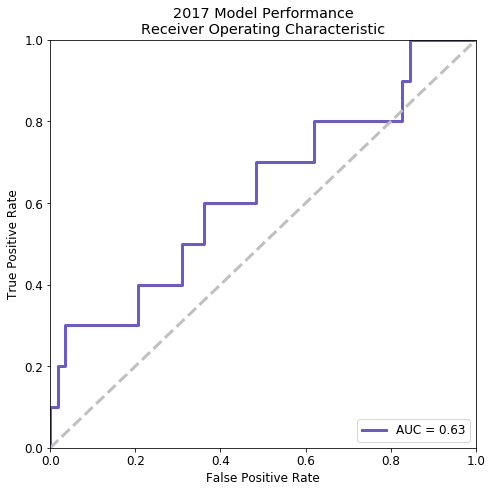

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

def plot_roc(probs, holdout, title = '', save = False):
    
    #-----------------------------------------------------------
    # plots ROC curve for model performance
    #-----------------------------------------------------------
    import matplotlib
    font = {'family' : 'helvetica',
            'weight': 'normal',
        'size'   : 12, 
        }

    matplotlib.rc('font', **font)
    fpr, tpr, threshold = metrics.roc_curve(holdout, probs)
    roc_auc = metrics.auc(fpr, tpr)
    fig = plt.figure(figsize = (7,7))
    plt.title(title + '\nReceiver Operating Characteristic')
    plt.grid(b = None)
    plt.plot(fpr, tpr, 'slateblue',label = 'AUC = %0.2f' % roc_auc, linewidth = 3)
    plt.grid(False)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', linewidth = 3, color = 'silver' )
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    if save is True:
        plt.savefig(title + 'roc.png', transparent = True, dpi = 300)
    plt.show()
    


def run_model(train, holdout, cols, clf = LogisticRegression(C = .05), thresh = .45, plot_on = True, title = ''):
        
    #-----------------------------------------------------------
    # runs sklearn LogsticRegression model on train and holdout set, outputs CV score and plots ROC
    #-----------------------------------------------------------

    clf.fit(train['X'][cols], train['y'])
    predicted = clf.predict(holdout['X'][cols])
    probs = clf.predict_proba(holdout['X'][cols])
    probs = probs[:,1]
#     probs[probs < thresh] = 0
#     probs = np.where(probs > thresh, 1, 0)

    print('Mean Accuracy: %0.2f' % metrics.accuracy_score(holdout['y'], predicted) )
    print('Classification Report: \n', metrics.classification_report(holdout['y'], predicted))
    print('Confusion Matrix: \n', metrics.confusion_matrix(holdout['y'], predicted))
    score = cross_val_score(clf, train['X'], train['y'], cv = 10, scoring= 'roc_auc').mean()
    print('Cross validation score: {}'.format(score))

    plot_roc(probs, holdout['y'], title)
    
    return clf


clf = run_model(train, holdout, cols = train['X'].columns.values, title = f'{str(predict_year)} Model Performance')



### Oversampling the minority class in the training set should help with model perforamnce
We can use the SMOTE algorithm, which uses K-means to generate artificial data points to draw from – bootstrapping model classification

Mean Accuracy: 0.74
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.79      0.84        58
           1       0.25      0.40      0.31        10

    accuracy                           0.74        68
   macro avg       0.57      0.60      0.57        68
weighted avg       0.79      0.74      0.76        68

Confusion Matrix: 
 [[46 12]
 [ 6  4]]
Cross validation score: 0.7579780321424442


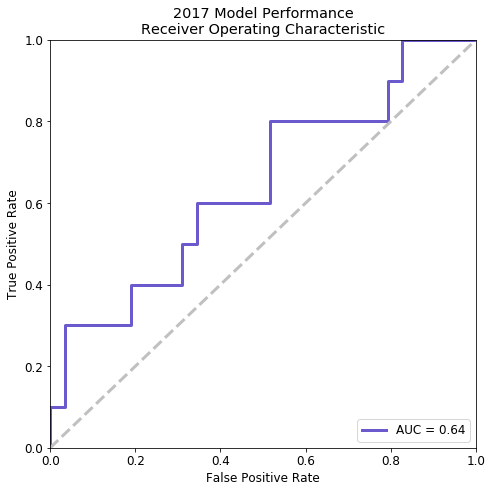

In [16]:
def make_resampled(X,y):
    #-----------------------------------------------------------
    # Uses SMOTE algorithm to oversample minority (LOSES michelin star)
    # class. Helpful to improve model performance.
    #-----------------------------------------------------------
    sm = SMOTE()
    X_new, y_new = sm.fit_sample(X, y)

    return  pd.DataFrame(X_new, columns = X.columns), pd.Series(y_new)

resampled_train = dict()
resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])
clf = run_model(resampled_train, holdout, cols = train['X'].columns.values, title = f'{str(predict_year)} Model Performance')




### Feature and parameter tuning
#### Create a pipeline to find ideal parameters with feature reduction using PCA

Best parameter (CV score=0.744):
{'logistic__C': 100, 'pca__n_components': 64}


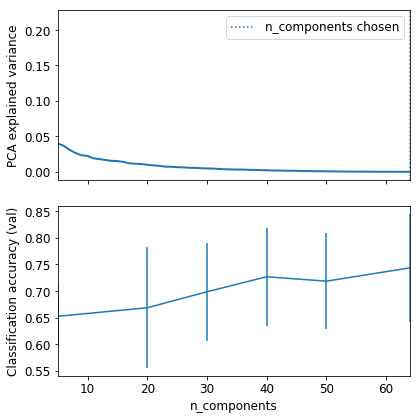

Mean Accuracy: 0.74
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.79      0.84        58
           1       0.25      0.40      0.31        10

    accuracy                           0.74        68
   macro avg       0.57      0.60      0.57        68
weighted avg       0.79      0.74      0.76        68

Confusion Matrix: 
 [[46 12]
 [ 6  4]]
Cross validation score: 0.757082090415077


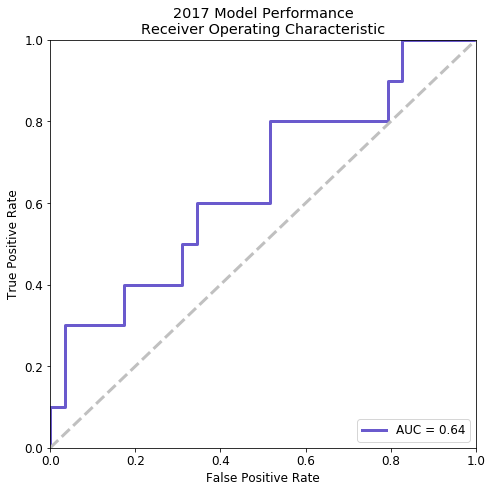

({'X':            0         1         2         3         4         5         6   \
  0    0.124669  1.712738 -0.399867 -0.463765  0.488636  0.369695  0.244012   
  1    0.906837  0.540206  0.195650 -0.938090 -0.209116  0.885239  0.265450   
  2    0.186036 -0.464843 -0.851508 -0.557003  0.357233  0.194437  0.773344   
  3    0.901087  1.169350 -0.562353 -0.059009 -0.352080  0.579620  0.675598   
  4    1.407732  1.013930  0.273128  0.952786 -0.375894  1.035281  0.425383   
  5    0.145388  0.280404 -0.222965  0.439512 -0.499936  0.729796 -0.105323   
  6    0.089896  0.500132 -0.049578 -0.562483  1.205530  0.272018 -0.009674   
  7   -0.186252  0.222606 -0.363920  0.110813 -0.488266  0.214322  0.507420   
  8    1.157778  0.448720 -0.601691 -0.425141  0.880233  0.505279  0.304499   
  9   -0.169018  0.447194 -0.191631 -0.278833  0.680962  0.524589  0.067367   
  10   1.731129  0.106849 -0.554316  0.088292  0.283932  1.096255  0.113855   
  11  -0.033808  1.195955 -0.153229 -0.066789 -

In [17]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def feature_reduction_pipeline(train, holdout):
    # Define a pipeline to search for the best combination of PCA truncation
    # and classifier regularization.
    logistic = LogisticRegression()
    pca = PCA()
    
    def make_grid_search_pipeline():
        pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])



        # Parameters of pipelines can be set using ‘__’ separated parameter names:
        param_grid = {
            'pca__n_components': [5, 20, 30, 40, 50, 64],
            'logistic__C' : [.01, .05, 1, 5, 10, 100]
        }
        search = GridSearchCV(pipe, param_grid, iid=False, cv=10)
        search.fit(resampled_train['X'], resampled_train['y'])
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print(search.best_params_)
        return search

    # Plot the PCA spectrum
    def plot_outcomes():
        fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
        ax0.plot(pca.explained_variance_ratio_, linewidth=2)
        ax0.set_ylabel('PCA explained variance')

        ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
                    linestyle=':', label='n_components chosen')
        ax0.legend(prop=dict(size=12))

        # For each number of components, find the best classifier results
        results = pd.DataFrame(search.cv_results_)
        components_col = 'param_pca__n_components'
        best_clfs = results.groupby(components_col).apply(
            lambda g: g.nlargest(1, 'mean_test_score'))

        best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
                       legend=False, ax=ax1)
        ax1.set_ylabel('Classification accuracy (val)')
        ax1.set_xlabel('n_components')

        plt.tight_layout()
        plt.show()
        
    pca.fit(train['X'])
    search = make_grid_search_pipeline()
    plot_outcomes()
    
    def evaluate_reduced_data():
        train_component   = dict()
        holdout_component = dict()
        train_component['X']    = pd.DataFrame(pca.transform(train['X'])[:,:search.best_params_['pca__n_components']], columns = None)
        train_component['y']    = resampled_train['y']
        holdout_component['X']  = pd.DataFrame(pca.transform(holdout['X'])[:,: search.best_params_['pca__n_components']] , columns = None)
        holdout_component['y']  = holdout['y']

        clf = run_model(train_component, 
                holdout_component, 
                cols = train_component['X'].columns, 
                title = f'{str(predict_year)} Model Performance')
    
        return train_component, holdout_component
    
    return evaluate_reduced_data()
    
feature_reduction_pipeline(resampled_train, holdout)

### See if recursive feature selection improves model performance

Optimal number of features :27


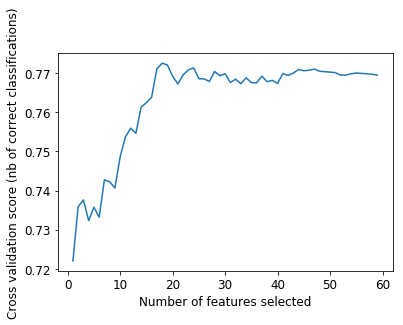

Mean Accuracy: 0.74
Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.79      0.84        58
           1       0.25      0.40      0.31        10

    accuracy                           0.74        68
   macro avg       0.57      0.60      0.57        68
weighted avg       0.79      0.74      0.76        68

Confusion Matrix: 
 [[46 12]
 [ 6  4]]
Cross validation score: 0.7579780321424442


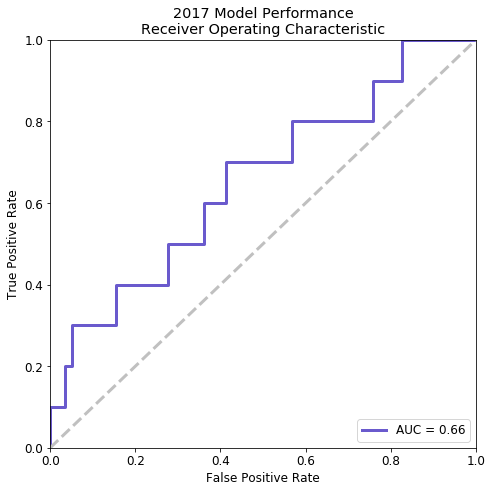

In [18]:
from sklearn.feature_selection import RFECV
def get_rfecv_features(train, clf = LogisticRegression()):
    rfecv = RFECV(estimator=clf, step=1, cv=10,
                  scoring='roc_auc', min_features_to_select = 10)

    rfecv.fit(train['X'], train['y'])
    selected_cols = train['X'].columns[rfecv.support_]

    print("Optimal number of features :{}".format(rfecv.n_features_) )

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return selected_cols

selected_features = get_rfecv_features(resampled_train, clf = LogisticRegression(C = .1))
clf = run_model(resampled_train, holdout, cols = selected_features, title = f'{str(predict_year)} Model Performance')




## Get train and holdout data for a specific year
Holdout data corresponds to all the yelp data up to 1 year + 100 days before 1/1 of the predicted year, holdout corresponds to all the data including up to 100 days before the predicted year

In [19]:
predict_year   = 2019
train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)


## Get a baseline model with logsitc regression to evaluate Michelin survival in 2019

Mean Accuracy: 0.79
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        53
           1       0.00      0.00      0.00        14

    accuracy                           0.79        67
   macro avg       0.40      0.50      0.44        67
weighted avg       0.63      0.79      0.70        67

Confusion Matrix: 
 [[53  0]
 [14  0]]
Cross validation score: 0.6512863829937


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


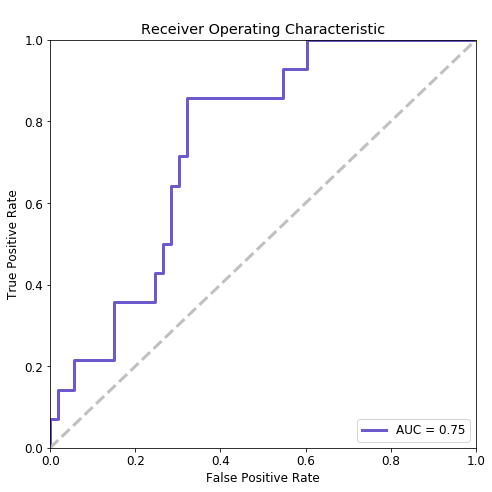

Cross validation score: 0.6512863829937


In [20]:
clf = SGDClassifier(loss = 'log')
clf = run_model(train, holdout, cols = train['X'].columns.values)
score = cross_val_score(clf, train['X'], train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))



## Resample to balanced classes using SMOTE

Mean Accuracy: 0.75
Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.86      0.77       414
           1       0.82      0.64      0.72       414

    accuracy                           0.75       828
   macro avg       0.76      0.75      0.74       828
weighted avg       0.76      0.75      0.74       828

Confusion Matrix: 
 [[356  58]
 [151 263]]
Cross validation score: 0.7094598358875575


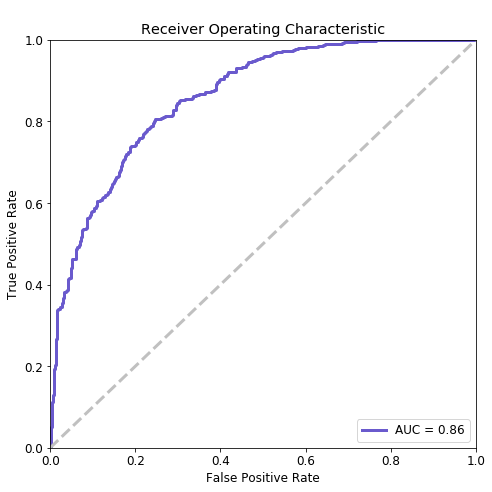

Cross validation score: 0.6954058363381044


In [21]:
resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])

clf = SGDClassifier(loss = 'log', penalty = 'elasticnet')
clf = run_model(resampled_train, resampled_train, cols = resampled_train['X'].columns,  clf = clf)

score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))


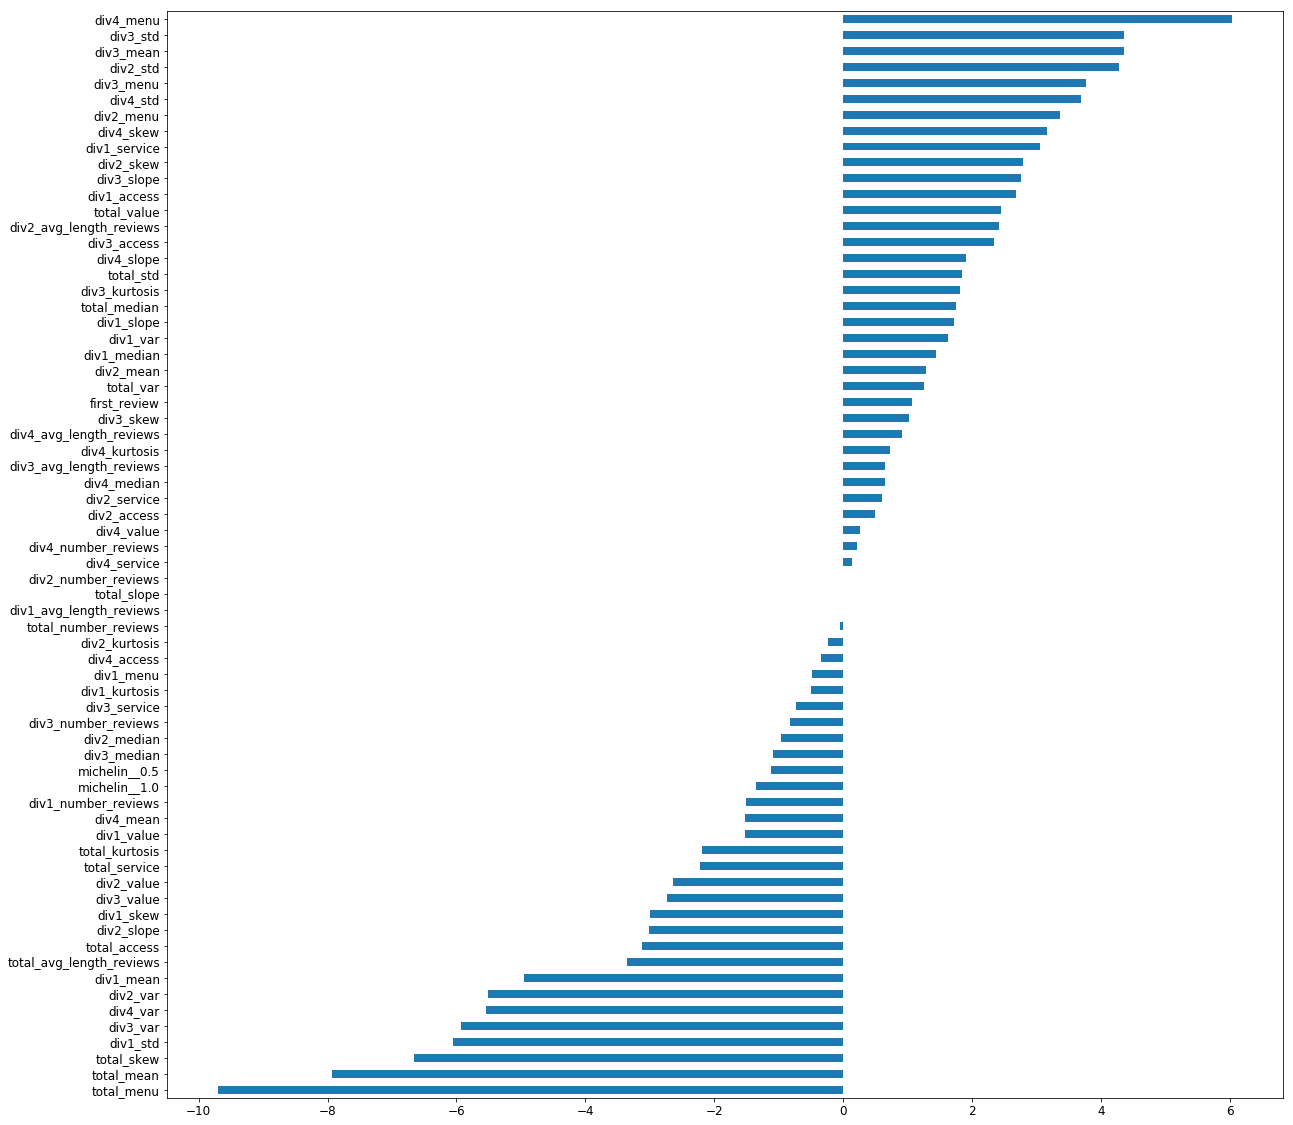

In [22]:
coefs_abs = pd.Series(clf.coef_[0], index = train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('all_importance.png', transparent = False, dpi = 300)

## Evaluate model on holdout set

Mean Accuracy: 0.72
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.77      0.81        53
           1       0.37      0.50      0.42        14

    accuracy                           0.72        67
   macro avg       0.61      0.64      0.62        67
weighted avg       0.75      0.72      0.73        67

Confusion Matrix: 
 [[41 12]
 [ 7  7]]
Cross validation score: 0.6986887596601201


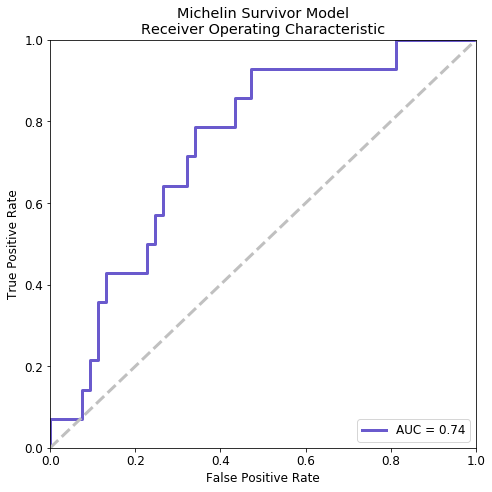

In [23]:
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns, title = 'Michelin Survivor Model')


## Feature elimination

Optimal number of features :60


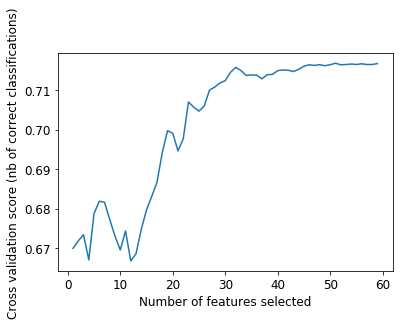

Mean Accuracy: 0.72
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.77      0.81        53
           1       0.37      0.50      0.42        14

    accuracy                           0.72        67
   macro avg       0.61      0.64      0.62        67
weighted avg       0.75      0.72      0.73        67

Confusion Matrix: 
 [[41 12]
 [ 7  7]]
Cross validation score: 0.6986887596601201


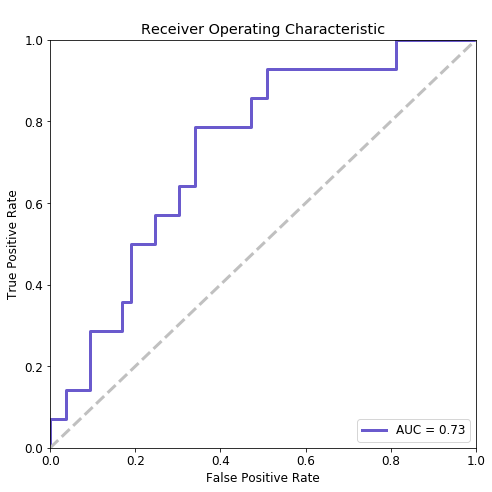

In [24]:

selected_cols = get_rfecv_features(resampled_train)
clf = run_model(resampled_train, holdout,   cols = selected_cols)

## Explore just rating data

Mean Accuracy: 0.79
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        53
           1       0.00      0.00      0.00        14

    accuracy                           0.79        67
   macro avg       0.40      0.50      0.44        67
weighted avg       0.63      0.79      0.70        67

Confusion Matrix: 
 [[53  0]
 [14  0]]
Cross validation score: 0.6484461338119875


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


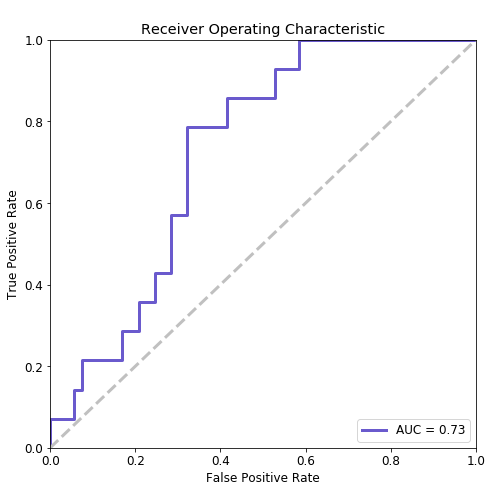

Mean Accuracy: 0.69
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.77      0.80        53
           1       0.29      0.36      0.32        14

    accuracy                           0.69        67
   macro avg       0.56      0.57      0.56        67
weighted avg       0.71      0.69      0.70        67

Confusion Matrix: 
 [[41 12]
 [ 9  5]]
Cross validation score: 0.7171106039084284


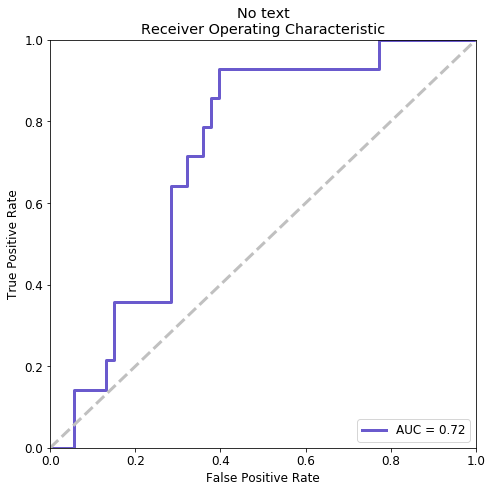

Cross validation score: 0.7171106039084284


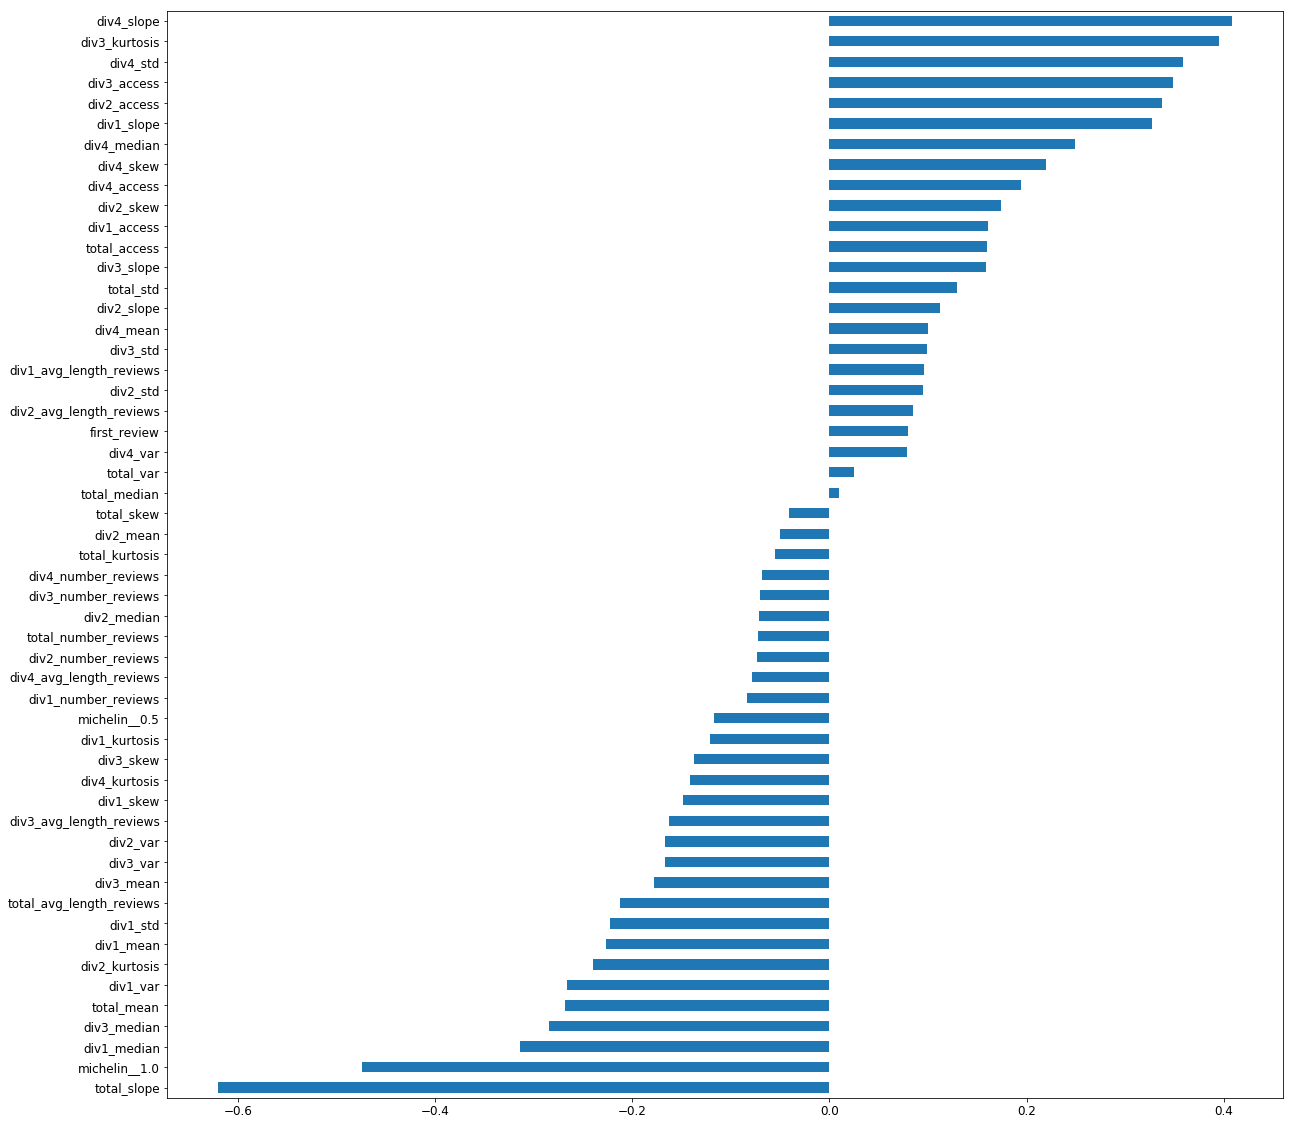

In [25]:
my_cols = list()
topics = ['wait time', 'service', 'value', 'menu']
for each in train['X'].columns:
    for topic in topics:
        if topic in each:
            my_cols.append(each)
no_text = dict()            
no_text['X'] = train['X'].drop(my_cols, axis = 1)
no_text['y'] = train['y'].copy()

run_model(no_text, holdout, cols = no_text['X'].columns)

resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(no_text['X'],no_text['y'])

clf = LogisticRegression(C = .05)
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns,  title ='No text')
coefs_abs = pd.Series(clf.coef_[0], index = resampled_train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('rating_importance.png', transparent = True, dpi = 300)

score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))



## Explore only text data

Mean Accuracy: 0.79
Classification Report: 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        53
           1       0.00      0.00      0.00        14

    accuracy                           0.79        67
   macro avg       0.40      0.50      0.44        67
weighted avg       0.63      0.79      0.70        67

Confusion Matrix: 
 [[53  0]
 [14  0]]
Cross validation score: 0.40435980009150735


/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


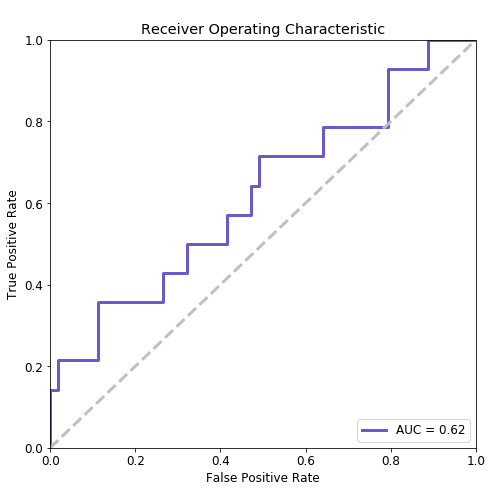

Mean Accuracy: 0.51
Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.53      0.63        53
           1       0.19      0.43      0.27        14

    accuracy                           0.51        67
   macro avg       0.49      0.48      0.45        67
weighted avg       0.66      0.51      0.55        67

Confusion Matrix: 
 [[28 25]
 [ 8  6]]
Cross validation score: 0.6362974001815677


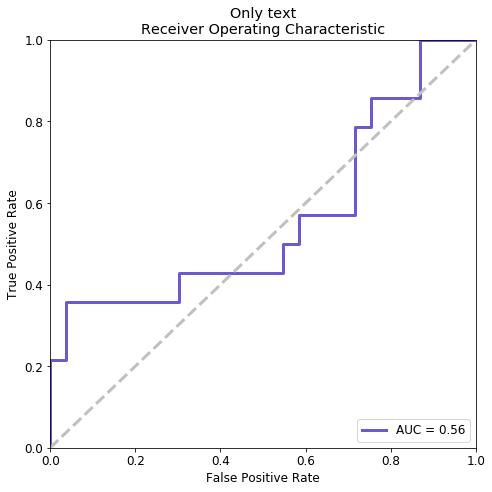

Cross validation score: 0.6362974001815677


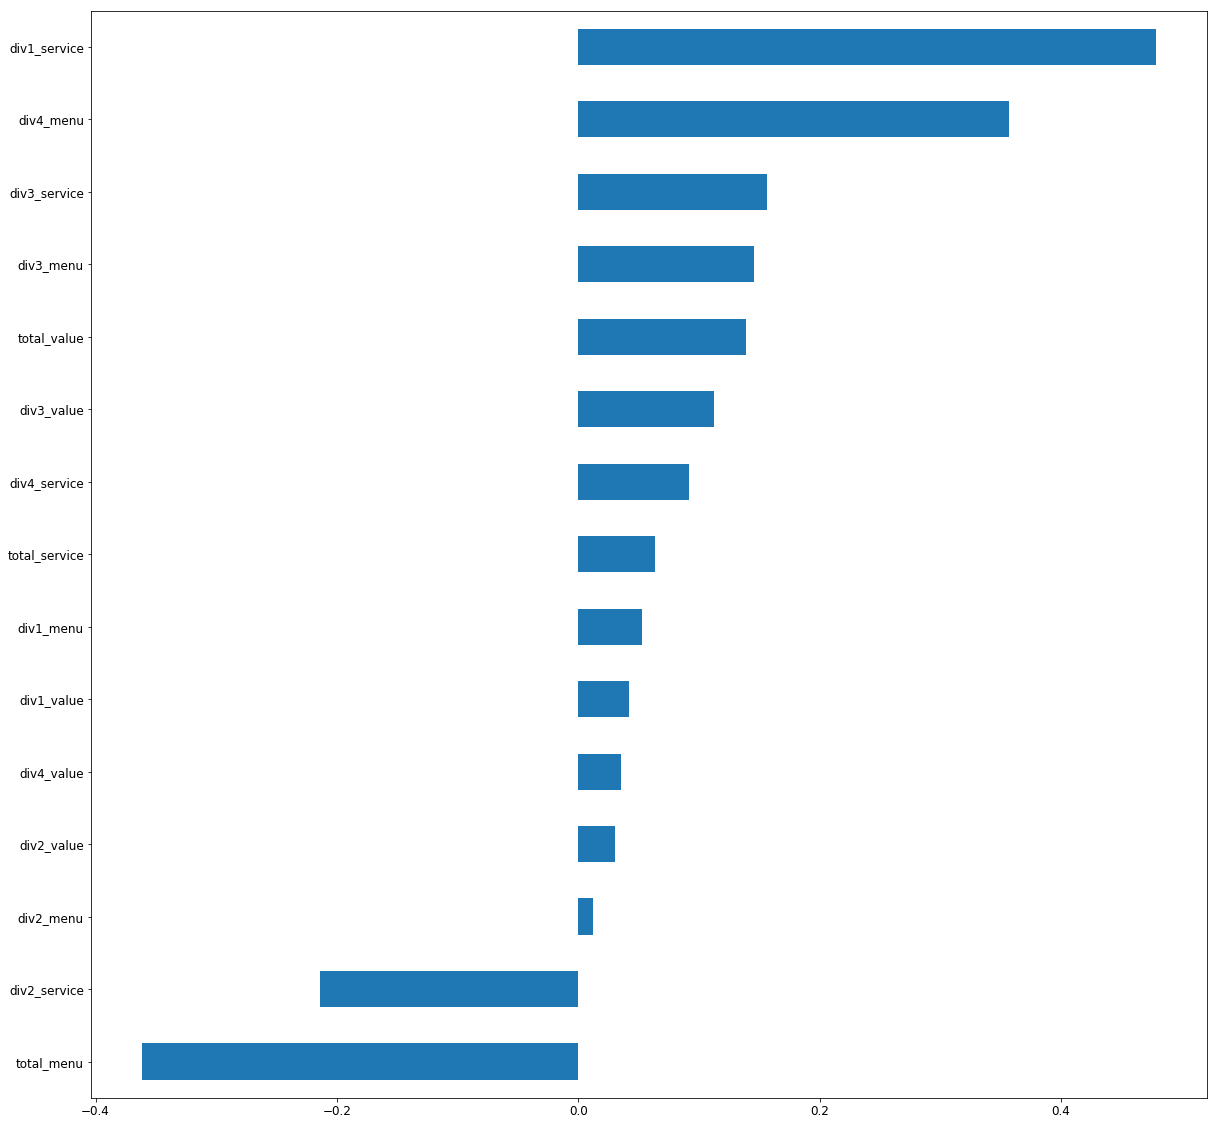

In [26]:
text = dict()            
text['X'] = train['X'][my_cols]
text['y'] = train['y'].copy()

run_model(text, holdout, cols = text['X'].columns)

resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
resampled_train['X'], resampled_train['y'] = make_resampled(text['X'],text['y'])

clf = LogisticRegression(C = .01)
clf = run_model(resampled_train, holdout, cols = resampled_train['X'].columns,   title = 'Only text')
coefs_abs = pd.Series(clf.coef_[0], index = resampled_train['X'].columns).sort_values(ascending = True)
coefs_abs.plot.barh(figsize = (20,20))
plt.savefig('text_importance.png', transparent = True, dpi = 300)


score = cross_val_score(clf, resampled_train['X'], resampled_train['y'], cv = 10, scoring= 'roc_auc').mean()
print('Cross validation score: {}'.format(score))


## Evaluate insights for at-risk restaurants for each year

Outputs csv for web-app

In [27]:
from sklearn.preprocessing import minmax_scale
predict_years   = [2020]

def produce_results(predict_year, michelin_data, yelp_data, thresh = .5):
    train, holdout = get_train_and_holdout(predict_year, michelin_data, yelp_data)
    df = holdout['X'].copy()
    resampled_train = {'X' : pd.DataFrame(), 'y': pd.Series()}
    resampled_train['X'], resampled_train['y'] = make_resampled(train['X'], train['y'])

    clf  = LogisticRegression(C = .05, random_state=0)
    clf.fit(resampled_train['X'], resampled_train['y'])

    probs = clf.predict_proba(holdout['X'])[:,1]
    
    thresh_probs = probs
#     thresh_probs[thresh_probs < thresh] = 0

    if predict_year != 2020:
        plot_roc(thresh_probs, holdout['y'], title = str(predict_year))
    
    at_risk = thresh_probs
    at_risk[at_risk > thresh] = 1
    at_risk[at_risk < thresh] = 0
    
    probs_pct = minmax_scale(probs, feature_range = (0, .99))
    probs_pct = pd.Series(probs_pct, index = holdout['X'].index)
    
    
    like             = 1 - minmax_scale(clf.predict_proba(holdout['X'])[:,1], feature_range=(0,1) )
    df['security']   = like
    like[like>.5]    = 0
    like[like!=0]    = 1
    
    df['at_risk']    = like
    df['actual']     = holdout['y']
    
    
    return df

data_dict = dict()
for predict_year in predict_years:
    data_dict[predict_year] = produce_results(predict_year, michelin_data, yelp_data)
    data_dict[predict_year].to_csv('datasets/michelin_{}_model_data_V2.csv'.format(str(predict_year)))
    

# main_points = ['total_median', 'total_slope','div4_food_quality', 'div4_menu',  'div4_service', 'div4_value']

### We'll use the log probabilities for 2020 to build our web_app predictions for Michelin Survivor